A notebook to make an animation of the currents and salinity.

In [1]:

from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools

from salishsea_tools import (nc_tools,viz_tools)

import os
import glob
from matplotlib import animation

import datetime

%matplotlib inline

Define date range

In [2]:
start = datetime.datetime(2014,11,12)
end = datetime.datetime(2014,11,19)

numdays = (end-start).days
dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]

In [3]:
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')


In [4]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob.glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

Load files over date range

In [5]:
#subset
ist=150
ien=350
jst=275
jen=475
depth=0
x=np.arange(ist,ien)
y=np.arange(jst,jen)

#initalize arrays
Us=np.zeros((1,y.shape[0],x.shape[0])); 
Vs=np.zeros((1,y.shape[0],x.shape[0]))
Ss=np.zeros((1,y.shape[0],x.shape[0]))
time=np.array([])

#lats and lons
lat = bathy.variables['nav_lat'][jst:jen,ist:ien]
lon = bathy.variables['nav_lon'][jst:jen,ist:ien]

#loop through files
for date in dates:
    results_dir = os.path.join(results_home, date.strftime('%d%b%y').lower())
    grid_U = results_dataset('1h','grid_U',results_dir)
    grid_V = results_dataset('1h','grid_V',results_dir)
    grid_T = results_dataset('1h','grid_T',results_dir)
    
    #load variables
    U = grid_U.variables['vozocrtx'][:,0,jst-1:jen,ist-1:ien]
    V = grid_V.variables['vomecrty'][:,0,jst-1:jen,ist-1:ien]
    S = grid_T.variables['vosaline'][:,0,jst:jen,ist:ien]

    #masking
    U = np.ma.masked_values(U,0)
    V = np.ma.masked_values(V,0)

    #unstagger
    u,v = viz_tools.unstagger(U,V)
    #rotate
    theta = np.pi*29/180
    uE = u*np.cos(theta) - v*np.sin(theta)
    vN = u*np.sin(theta) +v*np.cos(theta)
    

    #append
    Us = np.append(Us,uE,axis=0)
    Vs = np.append(Vs,vN,axis=0)
    Ss = np.append(Ss,S,axis=0)
    
    t = nc_tools.timestamp(grid_T, np.arange(S.shape[0]))
    for ind in range(len(t)):
        t[ind] = t[ind].datetime
    time = np.append(time, t)
    
#masking
Us=Us[1:,:,:]; Us=np.ma.masked_values(Us,0)
Vs=Vs[1:,:,:]; Vs=np.ma.masked_values(Vs,0)
Ss=Ss[1:,:,:];

Testing out the size and colors before animating

In [6]:
def quiver_salinity(t):
    ax.clear()
    #mesh
    mesh=ax.contourf(lon,lat,Ss[t],cs,cmap=cmap,extend='both')
    #land
    viz_tools.plot_land_mask(ax,bathy,coords='map',xslice=x,yslice=y,color='burlywood')
    #quivers
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], Us[t,::st,::st], Vs[t,::st,::st],
                       pivot='mid', width=0.003,scale=25, color='white',
                       headwidth=2,headlength=2)
    ax.quiverkey(quiver,-123.8,48.8, 1, '1 m/s',
                 coordinates='data', color='white', labelcolor='white')
    
    #title
    timestamp = time[t]
    ax.set_title(timestamp.strftime('%d-%b-%Y %H:%M'))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    return mesh

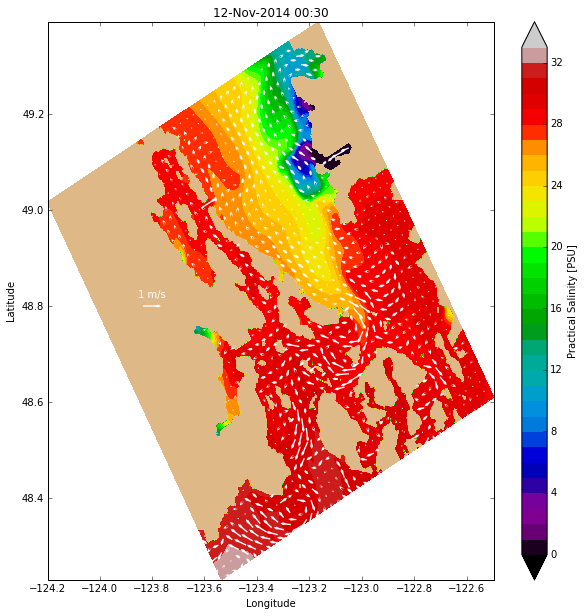

In [7]:
smin, smax, dels = 0, 34, 1
cs = np.arange(smin,smax)
cmap = plt.get_cmap('spectral')
st=5

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
t=0


mesh = quiver_salinity(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')

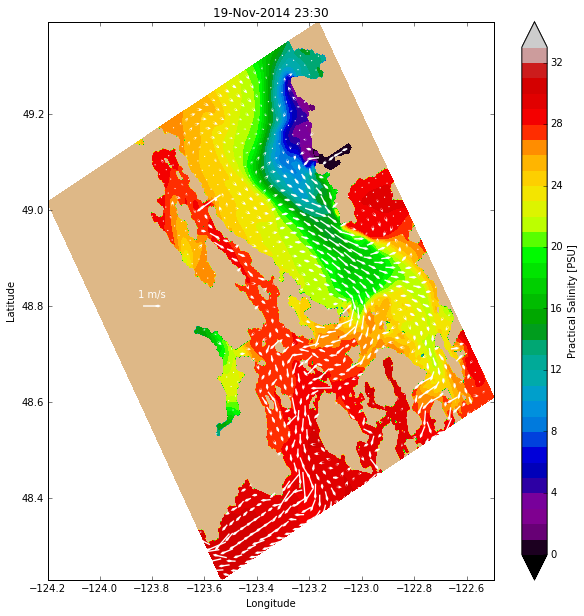

In [8]:
#Setting up first frame and static content
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh = quiver_salinity(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity [PSU]')


#frmaes
framess=np.arange(1,Us.shape[0])

#The animation function    
anim = animation.FuncAnimation(fig, quiver_salinity,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)

#Save in current folder
anim.save('currents-Nov2014.mp4',writer=mywriter)

In [9]:
print Us[0,100,0]

--
